# Laboratory #5_1 : Object Detection with YOLO

At the end of this laboratory, you would get familiarized with

*   Object Detection
*   YOLO for Object Detection using Keras and TensorFlow

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# YOLOv3 for Object Detection

*   There are several open source implementations of each version of YOLO.
*   For this exercise, we would not be implementing the YOLO from scratch as it is a challenging model and requires many customized elements.
*   We would use an open source implementation of YOLOv3 available from Python Lessons github repo, implemented with TensorFlow 2.x.
*   More details about YOLO can be found [here](https://pjreddie.com/darknet/yolo/). Refer the site and also the [paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf) for better understanding.

## Clone the repo in the notebook

In [1]:
# navigate to the cloned repository

%cd TensorFlow-2.x-YOLOv3/

/Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3


In [2]:
# installing additional requirements using pip

! pip install -r requirements.txt

# Please note that some libraries would return error. 
# If they are not important dependecies, you can skip those errors.
# Pip installation might require restarting the notebook. 
# Follow the installation output

  Using cached wget-3.2.zip (10 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.3.1 (from -r requirements.txt (line 6)) (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu==2.3.1 (from -r requirements.txt (line 6))


## Loading pre-trained weights

*   Load the weights using any one of the methods

In [ ]:
#  download the weights to the filesystem 
# (Remember that this would not be persistent)
# If you need the weights to be persistent, upload the weights to your drive
# and load from the drive

!curl  https://pjreddie.com/media/files/yolov3.weights --output model_data/yolov3.weights

## Detecting objects in images

*   Run sample predictions using the pre-trained weights

In [3]:
from yolov3.utils import detect_image, Load_Yolo_model
from yolov3.configs import *

image_path = "./IMAGES/kite.jpg"
output_path = "./kite_pred.jpg"

yolo = Load_Yolo_model()

kite_predictions = detect_image(
    yolo, 
    image_path, 
    output_path, 
    input_size=YOLO_INPUT_SIZE, 
    show=False, 
    rectangle_colors=(255,0,0))

# You will find the predictions file saved in the output path
# all objects present in MS-COCO classes would be detected in the saved file

Loading Darknet_weights from: model_data/yolov3.weights


## Understanding Image Detection function

*   In this exercise, you have to write your own function for object detection (Each step would lead to replicating the existing function)

*   Load the input image and visualize the image using matplotlib
*   Please note that image read is different in matplotlib, skimage and opencv. You will need to do appropriate conversion if using opencv

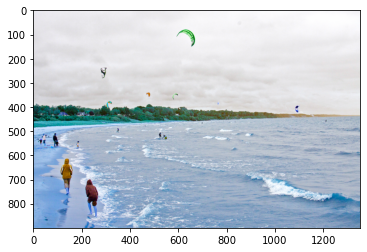

In [4]:
# solution
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(image_path)
plt.imshow(img)


*   Load the configurations

In [5]:
# open the configs.py file to understand the different configuration parameters

from yolov3.configs import *

*   Load the pre-trained weights using the Load_Yolo_model fuction available in yolov3.utils

In [6]:
from yolov3.utils import Load_Yolo_model

yolo = Load_Yolo_model()

Loading Darknet_weights from: model_data/yolov3.weights


*   Preprocess the image according to the network to be used

In [7]:
import numpy as np
from yolov3.utils import image_preprocess

image_data = image_preprocess(np.copy(img), [YOLO_INPUT_SIZE, YOLO_INPUT_SIZE])
image_data = image_data[np.newaxis, ...].astype(np.float32)

print('Original image:', img.shape)
print('Processed image:', image_data.shape)

Original image: (900, 1352, 3)
Processed image: (1, 416, 416, 3)


### Prediction boxes

*   Predict bounding boxes using the predict method 

In [11]:
pred_bbox = yolo.predict(image_data)

*   Get the prediction statistics

In [9]:
print('Length of the prediction boxes =', len(pred_bbox))
print('Shape of each prediction box ')

for i in range(len(pred_bbox)):
    print('Shape of prediction box', i, 'is', pred_bbox[i].shape)

Length of the prediction boxes = 3
Shape of each prediction box 
Shape of prediction box 0 is (1, 52, 52, 3, 85)
Shape of prediction box 1 is (1, 26, 26, 3, 85)
Shape of prediction box 2 is (1, 13, 13, 3, 85)


*   Why is the length of prediction boxes 3?

**Solution**

The length of the bounding boxes indicate a couple of things: 

1. it was defined in the config.py file 
2. We can see that from the paper, they define S=7, B=2, this gives rise to 7x7x2 = 98. 
3. Now from those bounding boxes there is going to be a threshold value which is going to be responsible for discarding the boxes with a low value. This is a value that can be set manually. 
4. Lastly, there is the IOU score (Intersection over Union) which is used to identify and discard the overlapping boxes. 

*   What does the shape of each prediction box represent?
*   Which layer corresponds to each prediction box output?

**Solution**

1) The shape of the prediction box represent the confidence to which it surrounds the detected objects. As in, the shape is corresponding to the type of object we want to detect (tall, slim, or big and wide).

2) Fc layers on top of the CNN feature extractor. 

*   What does 85 represent in the last dimension of the prediction box shape?

**Solution**

Number of output channels corresponding to: 

$$B \cdot (5 + C) $$

*   What is the aim in having three prediction boxes array?
*   Why is it helpful?

**Solution**

******* ANSWER THIS ****************

*   Reshape the prediction boxes

In [10]:
import tensorflow as tf

pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
pred_bbox = tf.concat(pred_bbox, axis=0)

print(pred_bbox.shape)

(10647, 85)


*   What do you think happens in the previous cell (reshaping the prediction boxes)? Explain the code as per your understanding.
*   Why do you think this step is needed?

**Solution**

tf.reshape returns a new tensor with a new shape, in this case the parameter "shape" is equal to tf.shape(x)[-1], which means we will be taking the last value of the tensor which is the number of columns. From the documentation we can see that using the value -1 we can keep the tensor constant, such that we flatten it in 1D. 


=> Basically we are doing a np.squeeze on the initial three dimensions, we take:

[a, b, c, d, e] --> [b * c * d, e] 

*   What are anchor boxes? What is the significance of anchor boxes in YOLO?

**Solution**

******* ANSWER THIS ****************

*   Post process the prediction bounding boxes

In [ ]:
from yolov3.utils import postprocess_boxes

score_threshold = 0.3

bboxes = postprocess_boxes(pred_bbox, image, YOLO_INPUT_SIZE, score_threshold)

*   What is score threshold? What is the role of score threshold?

**Solution**
The score threshold is the one in control of how many bounding boxes we will see, it is a similar threshold to IOU. 

*   What happens when the score_threshold is low? What happens when it is high?

**Solution**

Low = more bounding boxes 
High = less bounding boxes 

### Non-maximum Supression

*   What is non-maximum supression? Why is it needed?
*   What happens in this step?

**Solution**

******* ANSWER THIS ****************

*   Apply NMS on the bounding boxes.

In [ ]:
from yolov3.utils import nms

iou_threshold = 0.45

bboxes = nms(bboxes, iou_threshold, method='nms')

*   What is the role of IoU Threshold? What happens when a IoU higher threshold is used?

**Solution**

******* ANSWER THIS ****************

In [ ]:
#  draw the predicted bounding boxes on the image

from yolov3.utils import draw_bbox

pred_image = draw_bbox(image, bboxes, CLASSES=YOLO_COCO_CLASSES, rectangle_colors='')

### Predicting output

*   Visualize the pred_image using matplotlib

In [ ]:
# solution



# YOLO training

*   In this exercise, the task is to train mnist dataset using YOLOv3-Tiny model
*   Load the YOLOv3-Tiny weights using any one of the methods
*   For this experiment, we would use MNIST as the training data
*   Please note that all the necessary code is already available in the repo

In [ ]:
# download the weights to the filesystem 
# (Remember that this would not be persistent)

! wget -P model_data https://pjreddie.com/media/files/yolov3-tiny.weights

### Prepare data

*   The model takes a long time to train even with GPU. In order to fasten the training process, let us change the number of training and testing images in **mnist/make_data.py** file.
```
images_num_train = 500  # line number 20 in make_data.py
images_num_test = 50  # line number 21 in make_data.py
```
*   PS: 
    *   The dataset is already available in the repository.
    *   The file can be opened by double clicking on the filename from the Files menu.


*   Prepare the dataset for training

In [ ]:
! python mnist/make_data.py

### Tensorboard Visualization

*   Tensorboard is a visualization toolkit that allows for tracking and visualizing metrics such as loss and accuracy.
*   We would get introduced to tensorboard visualization here.
*   More information can be seen [here](https://www.tensorflow.org/tensorboard)

In [ ]:
# Load the TensorBoard notebook extension

%load_ext tensorboard

### Train the network

*   Change the following train options in the **configs.py** file in the yolov3 folder
```
TRAIN_YOLO_TINY = True
# Replace the batch size with smaller number if the GPU size is not sufficient 
TRAIN_BATCH_SIZE = 128
# Replace the train epochs with smaller number for faster training
TRAIN_EPOCHS = 50
```



*   Train the model using MNIST dataset

In [ ]:
! python train.py

*   If your tensorboard does not load, try to follow the following gif.

![](https://i.stack.imgur.com/ENl6b.gif)

In [ ]:
# Visualize the training curves
# you can find the different loss curves by selecting custom scalars option
# in the top right drop down

%tensorboard --logdir /content/TensorFlow-2.x-YOLOv3/log/

*   Explain the loss used in YOLOv3

**Solution**

*(Double-click or enter to edit)*

...

### Predicting objects

*   Change the following option in the **detect_mnist.py** 
```
ID = random.randint(0, 50)  # depending on the number of images in test set
```
*   Change the following train options in the **configs.py** 
```
TRAIN_MODEL_NAME = f"{YOLO_TYPE}_custom_Tiny"
```

*   Run the detction script to find the outut

In [ ]:
! python detect_mnist.py

# You will find the predictions file saved in the output path

# Understanding Object Detection

*   What is the latest YOLO version available in literature? From the initial versions to the current version, what differences are made in each version?

**Solution**

*(Double-click or enter to edit)*

...

*   What are the other object detection frameworks available in the literature? 
*   How different are they compared with YOLO?

**Solution**

*(Double-click or enter to edit)*

...

*    What is the underlying algorithm behind YOLO? Explain each stage briefly.

**Solution**

*(Double-click or enter to edit)*

...

*   Explain the network architecture used in training YOLO

**Solution**

*(Double-click or enter to edit)*

...

*   What are the drawbacks in object detection frameworks?

**Solution**

*(Double-click or enter to edit)*

...


---

# **End of P5_1: Object Detection with YOLO**
Deadline for P5_1 submission in CampusVirtual is: **Monday, the 20th of December, 2021**